In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import mmcv
import importlib
import torch
import torchvision.transforms as transforms
from mmcv import Config
from mmcls.datasets.pipelines import Compose
from mmcls.models.builder import build_classifier
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from PIL import Image
import heapq
from mmseg.apis import inference_segmentor, init_segmentor
from mmseg.core.evaluation import get_palette
from mmseg.datasets.builder import build_dataset, build_dataloader, DATASETS
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import pandas
import json
import seaborn as sns
import seaborn.objects as so

import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    

from scripts import generate_statistics_single
from scripts import visualization_seg_masks
from scripts import generate_statistics
from scripts import generate_cams
from scripts import utils
from scripts.utils.pipeline import get_pipeline_torchvision
from scripts import generate_segs
from scripts import visualize_cam_results
from scripts.utils.BlurDataset import get_blurred_dataset
from scripts.utils import preprocessing, io
from scripts.utils.model import get_wrongly_classified
from scripts.utils.evaluation import compare_original_blurred, get_eval_metrics
from scripts import evaluate_effectiveness
from scripts.generate_blurred import generate_blurred
from scripts import generate_statistics_seaborn

Importing BlurSegments step into Pipeline


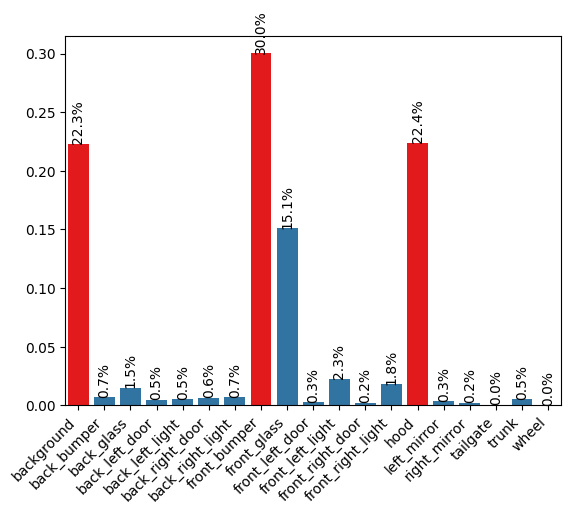

In [2]:
df = pandas.read_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx',
                       index_col=0)
ax = sns.barplot(data=df, x='segments', y='PercActivations', color = sns.color_palette("Paired")[1])
ax.set_xticklabels(df['segments'], rotation=45, ha="right")
ax.set(xlabel=None, ylabel=None)
print()
for i,b in enumerate(ax.patches):
    ax.text(b.get_x()+b.get_width()/2.0, b.get_height(), f'{b.get_height():.1%}', 
            ha='center', va='bottom', rotation=90)
    if i == 0 or i == 7 or i == 13:
        b.set_facecolor(sns.color_palette("Paired")[5])

In [2]:
classArray, loadedResults = utils.io.load_results_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx', 
                                     utils.constants.EXCELCOLNAMESSTANDARD)
eigensummarizedSegmentedCAMActivations = loadedResults['summarizedSegmentedCAMActivations']
eigensummarizedPercSegmentedCAMActivations = loadedResults['summarizedPercSegmentedCAMActivations']
eigentotalActivation = loadedResults['totalActivation'][0] # Since totalActivation is only a single value and only the first is relevant.
eigennumSamples = (int)(loadedResults['numSamples'][0])

eigendominantMask = utils.calculations.get_top_k(eigensummarizedSegmentedCAMActivations)
eigendominantMaskPercentual = utils.calculations.get_top_k(eigensummarizedPercSegmentedCAMActivations)

_, loadedResults = utils.io.load_results_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_EigenGradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx', 
                                     utils.constants.EXCELCOLNAMESSTANDARD)
eigengradsummarizedSegmentedCAMActivations = loadedResults['summarizedSegmentedCAMActivations']
eigengradsummarizedPercSegmentedCAMActivations = loadedResults['summarizedPercSegmentedCAMActivations']
eigengradtotalActivation = loadedResults['totalActivation'][0] # Since totalActivation is only a single value and only the first is relevant.
eigengradnumSamples = (int)(loadedResults['numSamples'][0])

eigengraddominantMask = utils.calculations.get_top_k(eigengradsummarizedSegmentedCAMActivations)
eigengraddominantMaskPercentual = utils.calculations.get_top_k(eigengradsummarizedPercSegmentedCAMActivations)

_, loadedResults = utils.io.load_results_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx', 
                                     utils.constants.EXCELCOLNAMESSTANDARD)
gradplussummarizedSegmentedCAMActivations = loadedResults['summarizedSegmentedCAMActivations']
gradplussummarizedPercSegmentedCAMActivations = loadedResults['summarizedPercSegmentedCAMActivations']
gradplustotalActivation = loadedResults['totalActivation'][0] # Since totalActivation is only a single value and only the first is relevant.
gradplusnumSamples = (int)(loadedResults['numSamples'][0])

gradplusdominantMask = utils.calculations.get_top_k(gradplussummarizedSegmentedCAMActivations)
gradplusdominantMaskPercentual = utils.calculations.get_top_k(gradplussummarizedPercSegmentedCAMActivations)

_, loadedResults = utils.io.load_results_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_LayerCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx', 
                                     utils.constants.EXCELCOLNAMESSTANDARD)
layersummarizedSegmentedCAMActivations = loadedResults['summarizedSegmentedCAMActivations']
layersummarizedPercSegmentedCAMActivations = loadedResults['summarizedPercSegmentedCAMActivations']
layertotalActivation = loadedResults['totalActivation'][0] # Since totalActivation is only a single value and only the first is relevant.
layernumSamples = (int)(loadedResults['numSamples'][0])

layerdominantMask = utils.calculations.get_top_k(layersummarizedSegmentedCAMActivations)
layerdominantMaskPercentual = utils.calculations.get_top_k(layersummarizedPercSegmentedCAMActivations)

_, loadedResults = utils.io.load_results_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_gradCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx', 
                                     utils.constants.EXCELCOLNAMESSTANDARD)
gradsummarizedSegmentedCAMActivations = loadedResults['summarizedSegmentedCAMActivations']
gradsummarizedPercSegmentedCAMActivations = loadedResults['summarizedPercSegmentedCAMActivations']
gradtotalActivation = loadedResults['totalActivation'][0] # Since totalActivation is only a single value and only the first is relevant.
gradnumSamples = (int)(loadedResults['numSamples'][0])

graddominantMask = utils.calculations.get_top_k(gradsummarizedSegmentedCAMActivations)
graddominantMaskPercentual = utils.calculations.get_top_k(gradsummarizedPercSegmentedCAMActivations)

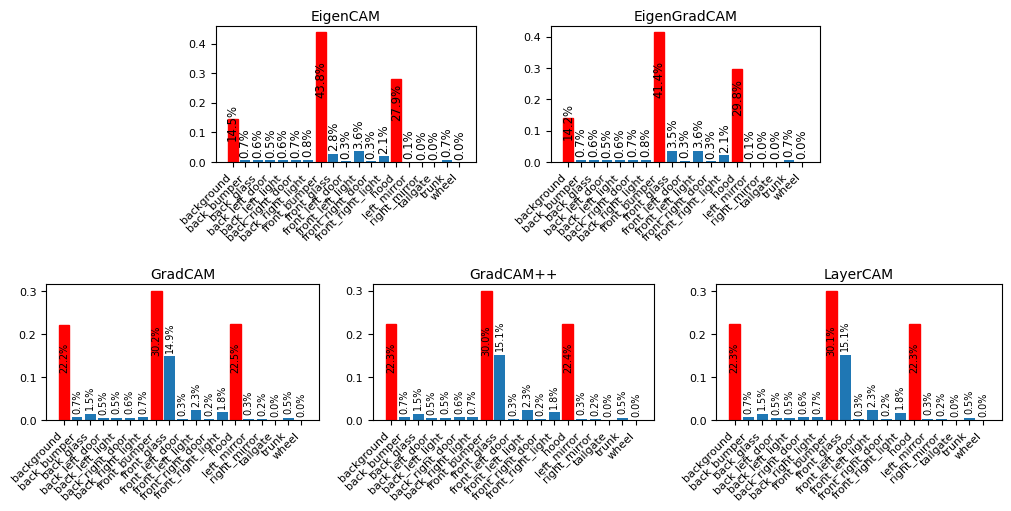

In [4]:
fig = plt.figure(figsize=(10,5), constrained_layout=True)
grid = fig.add_gridspec(2, 6, hspace=0.1)
tax1 = fig.add_subplot(grid[0,1:3])
tax2 = fig.add_subplot(grid[0,3:5])
bax1 = fig.add_subplot(grid[1,0:2])
bax2 = fig.add_subplot(grid[1,2:4])
bax3 = fig.add_subplot(grid[1,4:])
utils.plot.plot_bar(ax=tax1, x_ticks=classArray, data=eigensummarizedPercSegmentedCAMActivations, 
                    dominantMask=eigendominantMask, textrotation=90, textadjust_ypos=True, textfontsize='small')
tax1.tick_params(labelsize=8)
tax1.set_xlabel('EigenCAM')
tax1.xaxis.set_label_position('top') 
utils.plot.plot_bar(ax=tax2, x_ticks=classArray, data=eigengradsummarizedPercSegmentedCAMActivations, 
                    dominantMask=eigengraddominantMask, textrotation=90, textadjust_ypos=True, textfontsize='small')
tax2.tick_params(labelsize=8)
tax2.set_xlabel('EigenGradCAM')
tax2.xaxis.set_label_position('top') 
utils.plot.plot_bar(ax=bax1, x_ticks=classArray, data=gradsummarizedPercSegmentedCAMActivations, 
                    dominantMask=graddominantMask, textrotation=90, textadjust_ypos=True, textfontsize='x-small')
bax1.tick_params(labelsize=8)
bax1.set_xlabel('GradCAM')
bax1.xaxis.set_label_position('top') 
utils.plot.plot_bar(ax=bax2, x_ticks=classArray, data=gradplussummarizedPercSegmentedCAMActivations, 
                    dominantMask=gradplusdominantMask, textrotation=90, textadjust_ypos=True, textfontsize='x-small')
bax2.tick_params(labelsize=8)
bax2.set_xlabel('GradCAM++')
bax2.xaxis.set_label_position('top') 
utils.plot.plot_bar(ax=bax3, x_ticks=classArray, data=layersummarizedPercSegmentedCAMActivations, 
                    dominantMask=layerdominantMask, textrotation=90, textadjust_ypos=True, textfontsize='x-small')
bax3.tick_params(labelsize=8)
bax3.set_xlabel('LayerCAM')
bax3.xaxis.set_label_position('top') 
#plt.savefig('CAMComparison.pdf')

In [38]:
df = pandas.read_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/ResNet/Data_Full_EigenCAM_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx',
                      index_col=0)
df2 = pandas.read_excel('C:/Users/Linus/Desktop/copy/results/CompCars_Original/SwinBase/Data_Full_EigenCAM_SwinBase_CompCars_Original_ocrnet_hr48_carparts_noflip_23_08_2022.xlsx',
                      index_col=0)

In [6]:
df

,segments,RawActivations,PercActivations,totalActivation,numSamples
0,background,1827.092052,0.145180,168030528.0,13333.0
1,back_bumper,83.980438,0.006678,NaN,NaN
2,back_glass,77.983438,0.006198,NaN,NaN
3,back_left_door,66.004691,0.005239,NaN,NaN
4,back_left_light,73.179026,0.005805,NaN,NaN
5,back_right_door,87.763219,0.006956,NaN,NaN
6,back_right_light,97.740639,0.007755,NaN,NaN
7,front_bumper,5515.390687,0.437792,NaN,NaN
8,front_glass,346.084269,0.027684,NaN,NaN
9,front_left_door,40.186860,0.003189,NaN,NaN


Output path is not a directory. Using base directory: ..
Saving images to: ./modelComparison.pdf


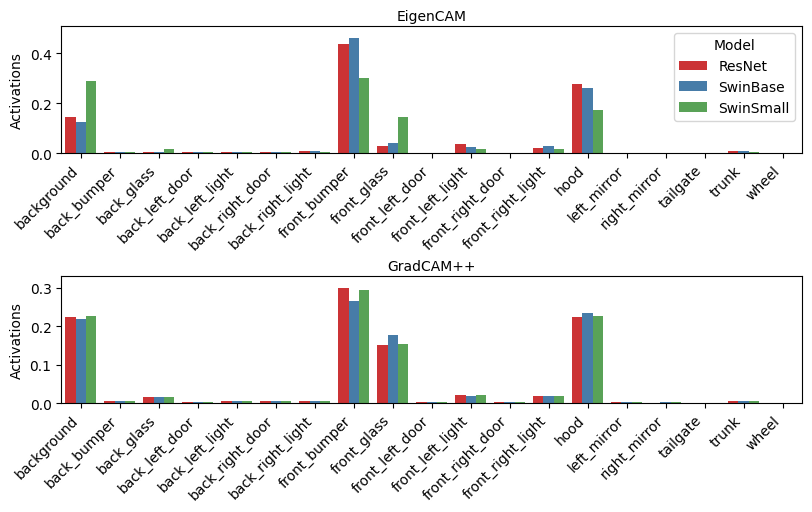

In [3]:
template='C:/Users/Linus/Desktop/copy/results/{dataset}/{Model}/Data_Full_{CAM}_{Model}_{dataset}_ocrnet_hr48_carparts_noflip_{date}.xlsx'

resEigen = template.format(Model='ResNet', dataset='CompCars_Original', date='23_08_2022', CAM='EigenCAM')
swinBaseEigen = template.format(Model='SwinBase', dataset='CompCars_Original', date='23_08_2022', CAM='EigenCAM')
swinSmallEigen = template.format(Model='SwinSmall', dataset='CompCars_Original', date='23_08_2022', CAM='EigenCAM')

resgradpp = template.format(Model='ResNet', dataset='CompCars_Original', date='23_08_2022', CAM='gradCAM++')
swinBasegradpp = template.format(Model='SwinBase', dataset='CompCars_Original', date='23_08_2022', CAM='gradCAM++')
swinSmallgradpp = template.format(Model='SwinSmall', dataset='CompCars_Original', date='23_08_2022', CAM='gradCAM++')

generate_statistics.generate_model_comparison([resEigen, swinBaseEigen, swinSmallEigen],
                                              [resgradpp, swinBasegradpp, swinSmallgradpp], 
                                              n_plots=2, save=True, title=['EigenCAM', 'GradCAM++'])


Output path is not a directory. Using base directory: ..
Saving images to: ./modelComparison.pdf


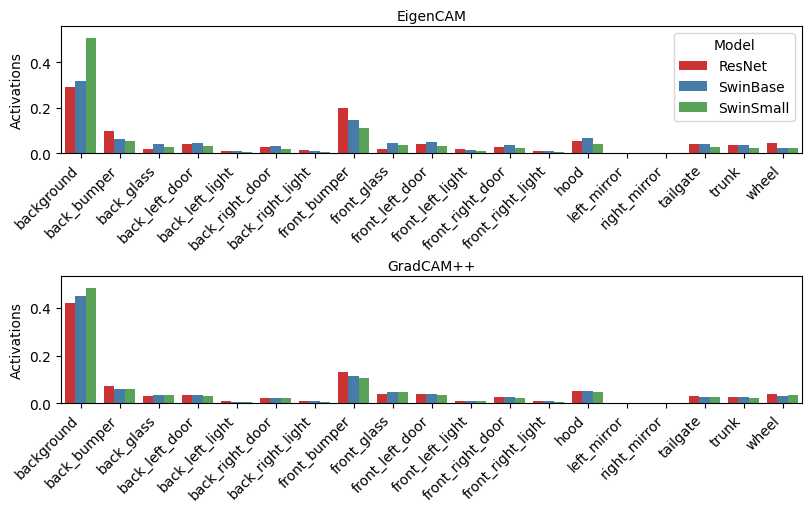

In [44]:
template='C:/Users/Linus/Desktop/copy/results/{dataset}/{Model}/Data_Full_{CAM}_{Model}_{dataset}_ocrnet_hr48_carparts_noflip_{date}.xlsx'

resEigen = template.format(Model='ResNet', dataset='CompCars_Web', date='23_08_2022', CAM='EigenCAM')
swinBaseEigen = template.format(Model='SwinBase', dataset='CompCars_Web', date='23_08_2022', CAM='EigenCAM')
swinSmallEigen = template.format(Model='SwinSmall', dataset='CompCars_Web', date='23_08_2022', CAM='EigenCAM')

resgradpp = template.format(Model='ResNet', dataset='CompCars_Web', date='23_08_2022', CAM='gradCAM++')
swinBasegradpp = template.format(Model='SwinBase', dataset='CompCars_Web', date='23_08_2022', CAM='gradCAM++')
swinSmallgradpp = template.format(Model='SwinSmall', dataset='CompCars_Web', date='23_08_2022', CAM='gradCAM++')

generate_statistics.generate_model_comparison([resEigen, swinBaseEigen, swinSmallEigen],
                                              [resgradpp, swinBasegradpp, swinSmallgradpp], 
                                              n_plots=2, save=True, title=['EigenCAM', 'GradCAM++'])


Output path is not a directory. Using base directory: ..
Saving images to: ./normalizedResGradppWeb.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./normalizedResEigenWeb.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./normalizedBaseGradppWeb.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./normalizedBaseEigenWeb.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./normalizedSmallGradppWeb.pdf
Output path is not a directory. Using base directory: ..
Saving images to: ./normalizedSmallEigenWeb.pdf


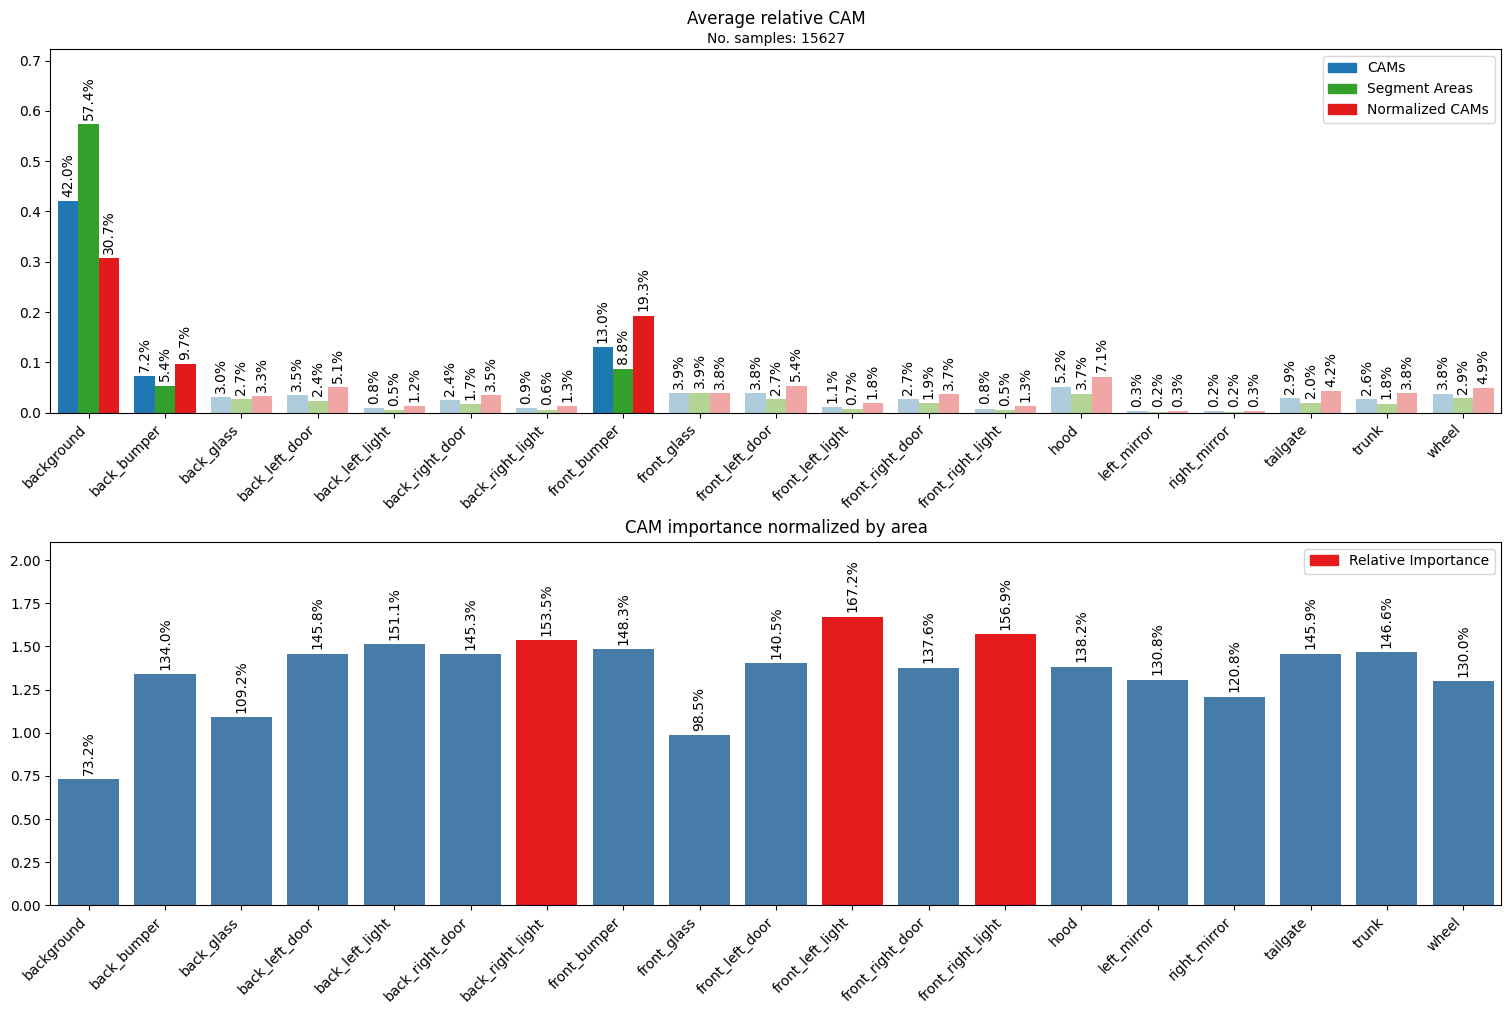

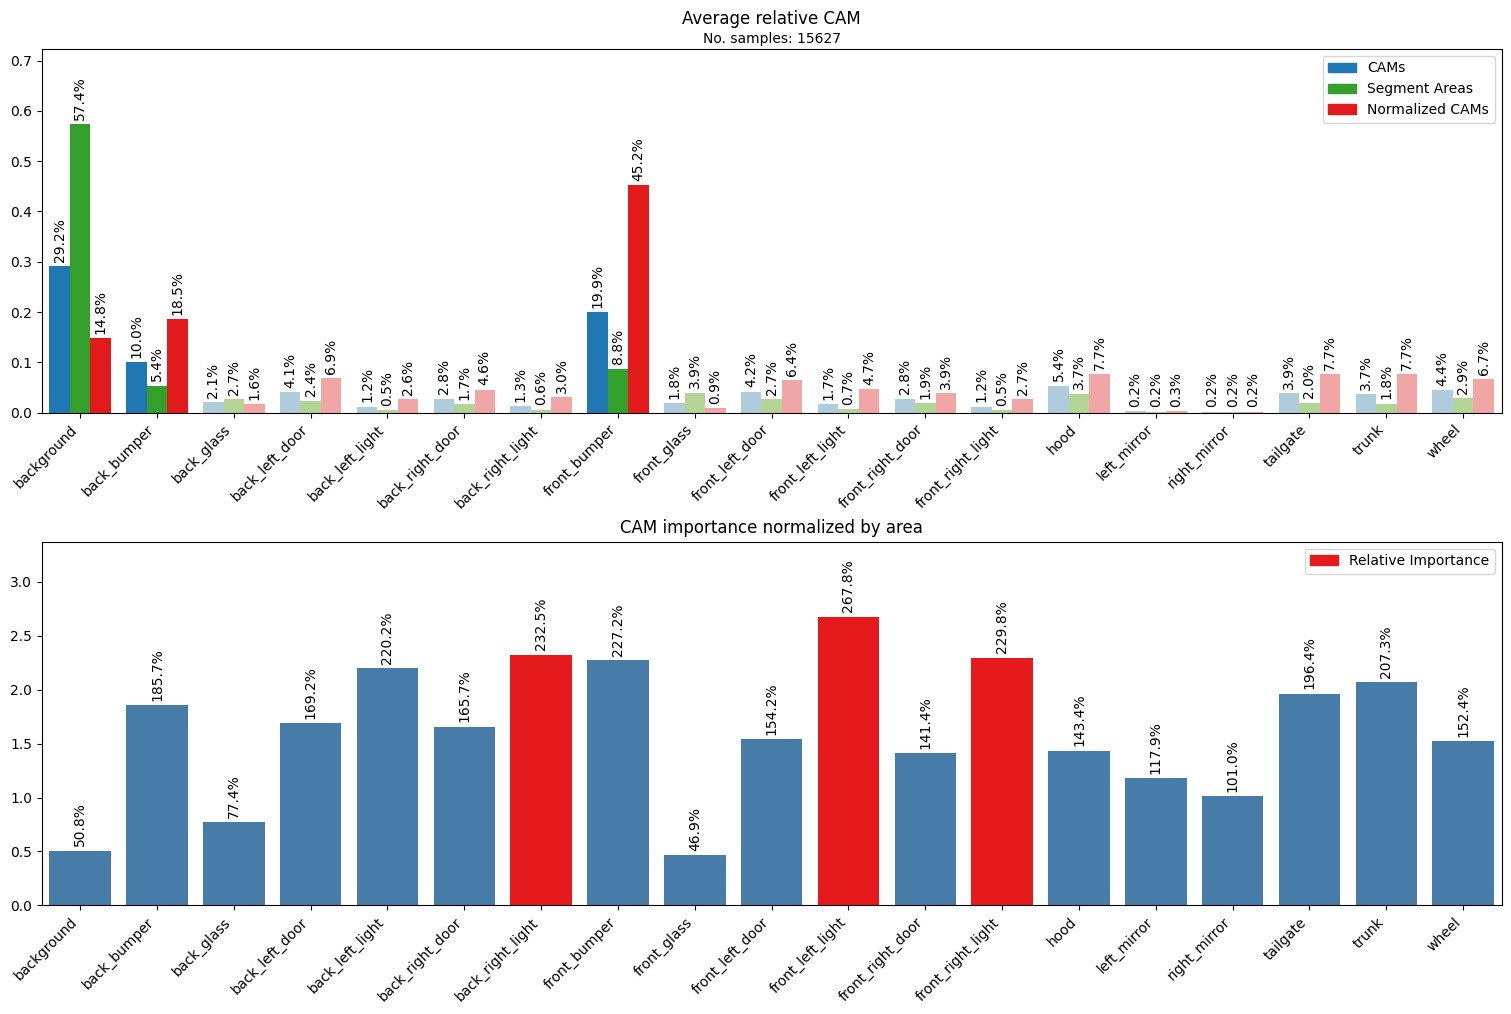

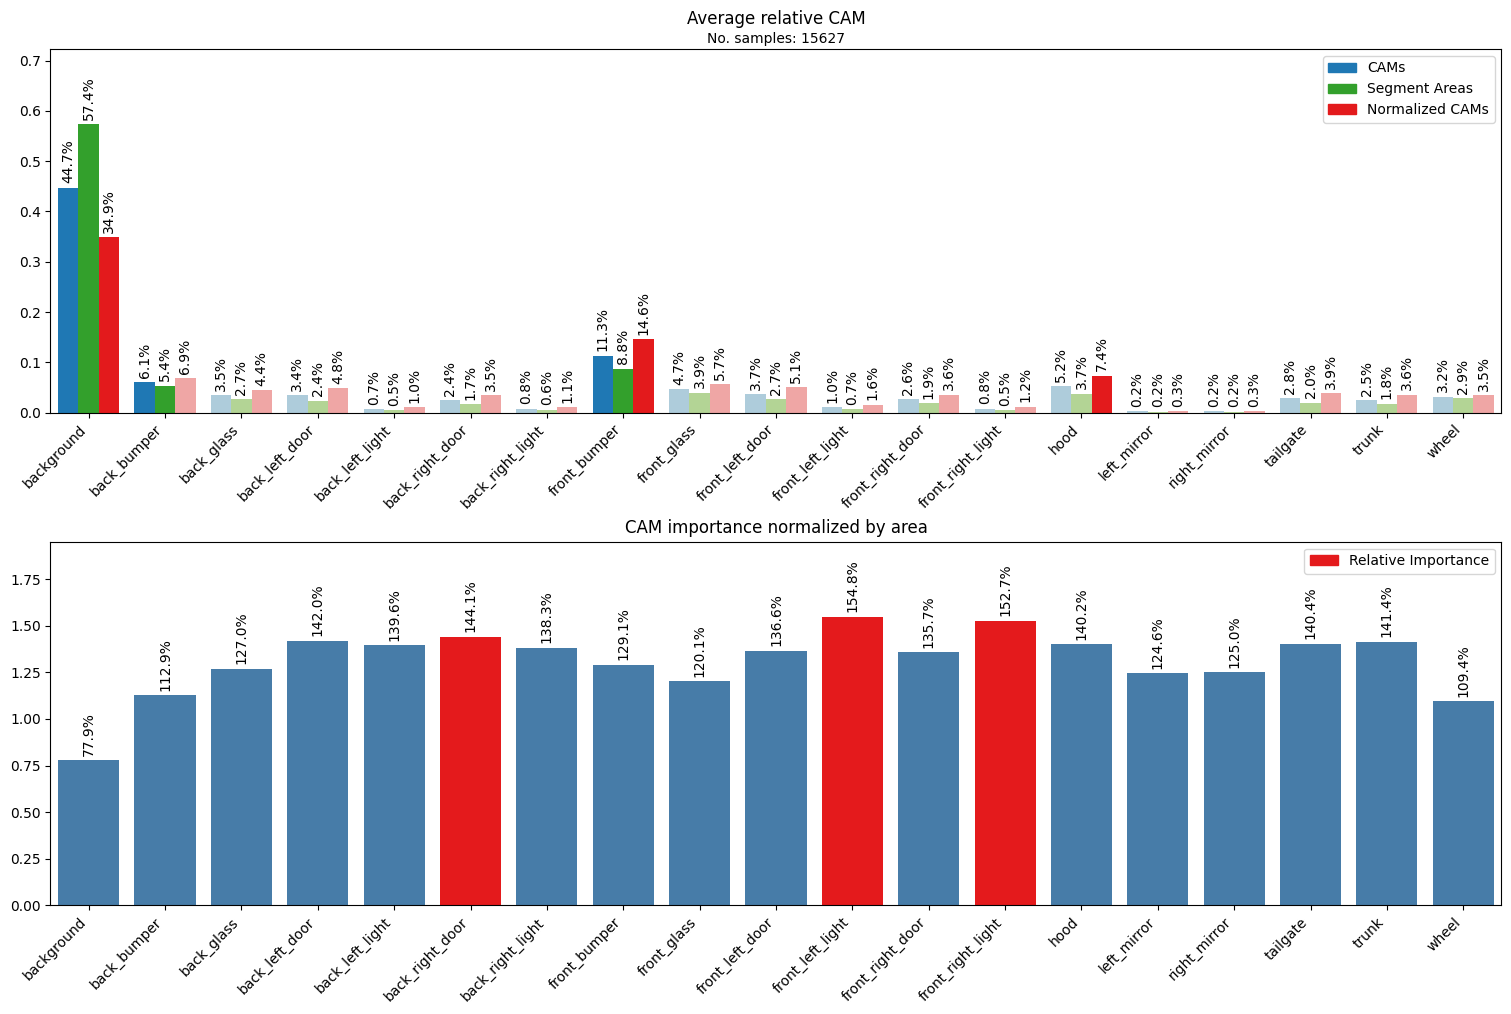

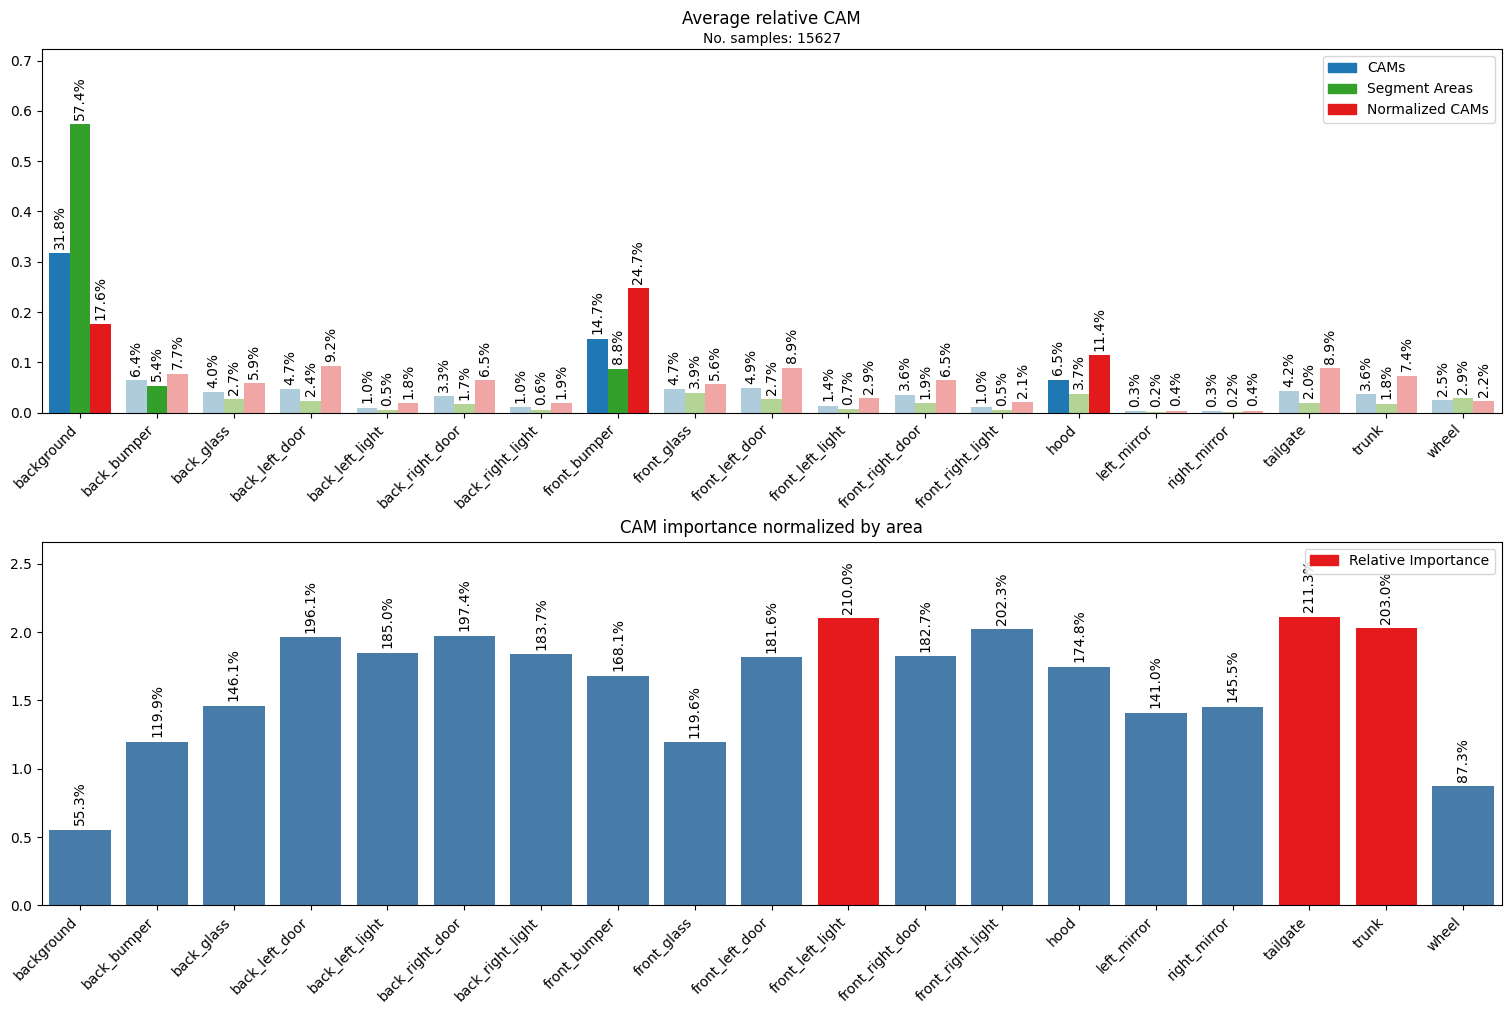

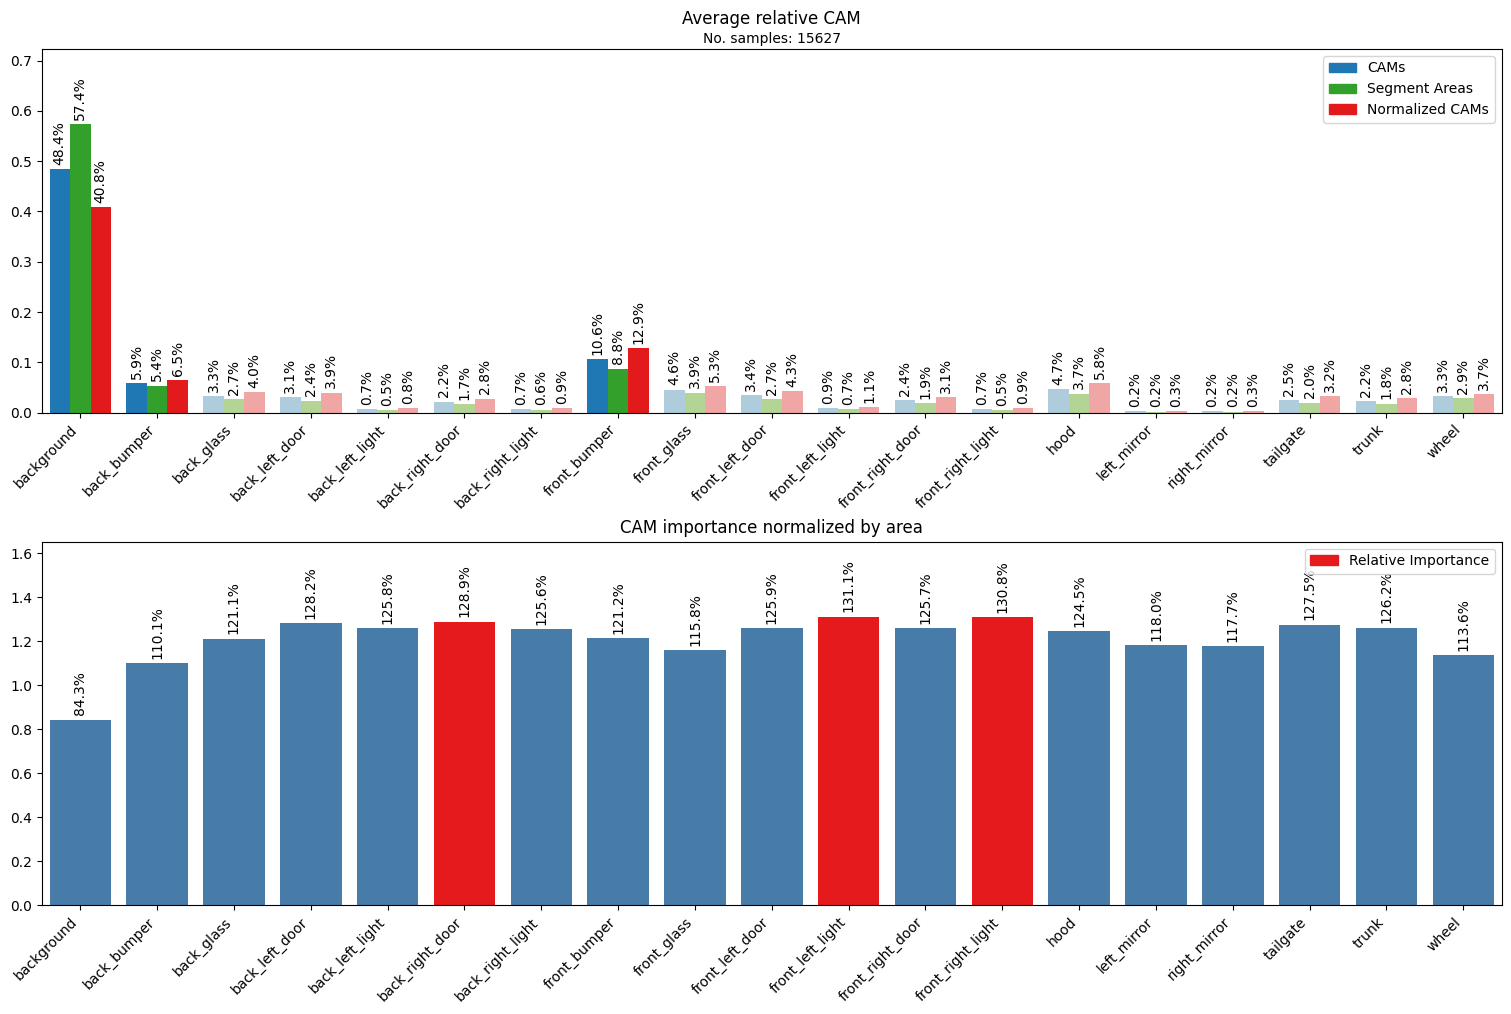

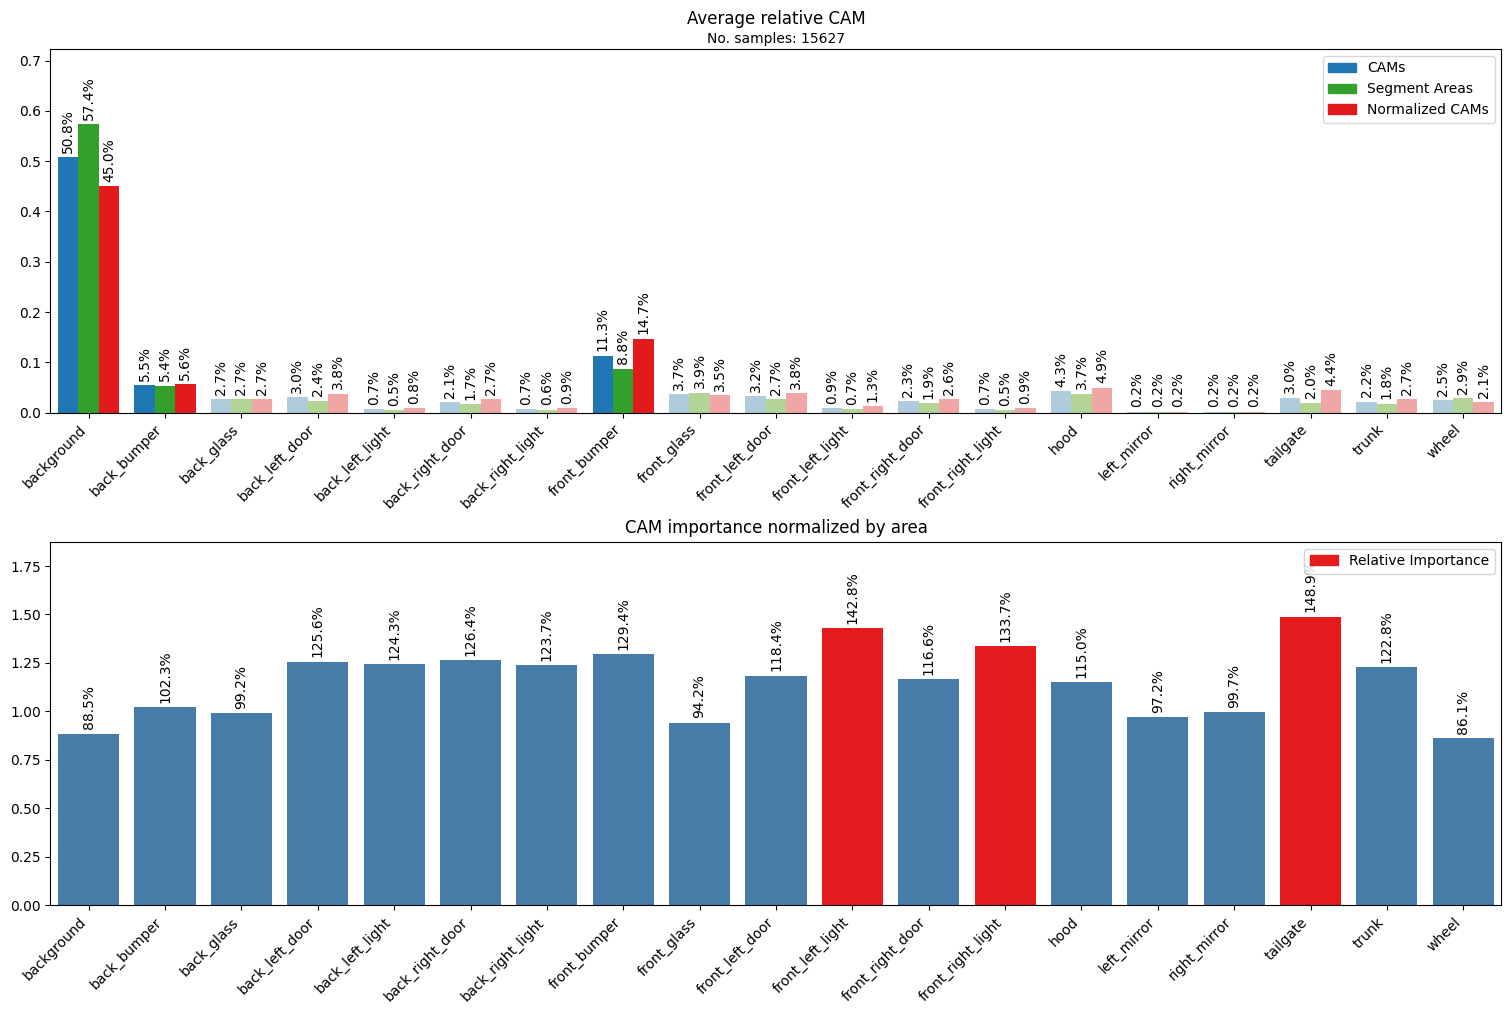

In [155]:
path = r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\normalized\Data_Full_gradCAM++_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx'
generate_statistics_seaborn.generate_normalized(path, n_samples=15627, y_axis_scale=1.2, file_name='normalizedResGradppWeb')
path = r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\ResNet\normalized\Data_Full_EigenCAM_ResNet_CompCars_Web_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx'
generate_statistics_seaborn.generate_normalized(path, n_samples=15627, y_axis_scale=1.2, file_name='normalizedResEigenWeb')

path = r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\normalized\Data_Full_gradCAM++_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx'
generate_statistics_seaborn.generate_normalized(path, n_samples=15627, y_axis_scale=1.2, file_name='normalizedBaseGradppWeb')
path = r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinBase\normalized\Data_Full_EigenCAM_SwinBase_CompCars_Web_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx'
generate_statistics_seaborn.generate_normalized(path, n_samples=15627, y_axis_scale=1.2, file_name='normalizedBaseEigenWeb')

path = r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\normalized\Data_Full_gradCAM++_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx'
generate_statistics_seaborn.generate_normalized(path, n_samples=15627, y_axis_scale=1.2, file_name='normalizedSmallGradppWeb')
path = r'C:\Users\Linus\Desktop\copy\results\CompCars_Web\SwinSmall\normalized\Data_Full_EigenCAM_SwinSmall_CompCars_Web_ocrnet_hr48_carparts_noflip_normalized_PropArea_23_08_2022.xlsx'
generate_statistics_seaborn.generate_normalized(path, n_samples=15627, y_axis_scale=1.2, file_name='normalizedSmallEigenWeb')

In [2]:
p = r'C:\Users\Linus\Desktop\copy\results\CompCars_Original\ResNet\meanStdTotal\Data_Full_gradCAM++_ResNet_CompCars_Original_ocrnet_hr48_carparts_noflip_Mean_Std_Total_23_08_2022.xlsx'
df = pandas.read_excel(p, index_col=0)

In [3]:
df

,segments,PercActivations,PercActivationsStd,RawActivations,RawActivationsStd,PercSegmentAreas,PercSegmentAreasStd,RawSegmentAreas,RawSegmentAreasStd,totalMean,totalStd
0,background,0.223116,0.151757,5659.956884,3763.962471,0.336572,0.129750,16887.829221,6510.342019,25497.787109,2239.393066
1,back_bumper,0.006806,0.006268,173.012722,148.964414,0.006694,0.004806,335.855996,241.150792,NaN,NaN
2,back_glass,0.015207,0.033013,389.135345,863.829568,0.019240,0.044433,965.366534,2229.448173,NaN,NaN
3,back_left_door,0.004756,0.001691,121.198100,42.589840,0.004203,0.001347,210.880672,67.570207,NaN,NaN
4,back_left_light,0.005123,0.001185,130.649284,31.911945,0.004408,0.001016,221.164329,50.998478,NaN,NaN
5,back_right_door,0.006459,0.006903,164.375202,174.034566,0.005614,0.006587,281.663842,330.488995,NaN,NaN
6,back_right_light,0.006757,0.001618,172.316644,43.131233,0.005857,0.001392,293.859821,69.869320,NaN,NaN
7,front_bumper,0.300205,0.095439,7644.286855,2433.920916,0.228911,0.069350,11485.834771,3479.705995,NaN,NaN
8,front_glass,0.150982,0.065100,3890.505211,1798.558901,0.193683,0.080292,9718.250281,4028.725619,NaN,NaN
9,front_left_door,0.002523,0.002986,64.167205,70.241804,0.001817,0.002137,91.145129,107.223959,NaN,NaN


<AxesSubplot: xlabel='segments', ylabel='PercActivations'>

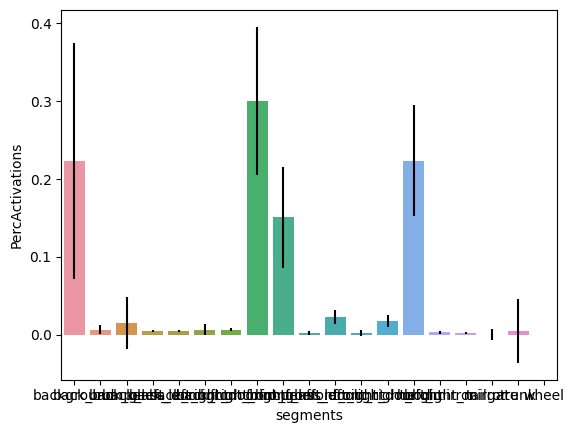

In [7]:
sns.barplot(data=df, x='segments', y='PercActivations', yerr=list(df['PercActivationsStd']))

In [6]:
df['PercActivationsStd']

0     0.151757
1     0.006268
2     0.033013
3     0.001691
4     0.001185
5     0.006903
6     0.001618
7     0.095439
8     0.065100
9     0.002986
10    0.008949
11    0.004020
12    0.007812
13    0.071176
14    0.002045
15    0.001564
16    0.007434
17    0.041148
18    0.000326
Name: PercActivationsStd, dtype: float64